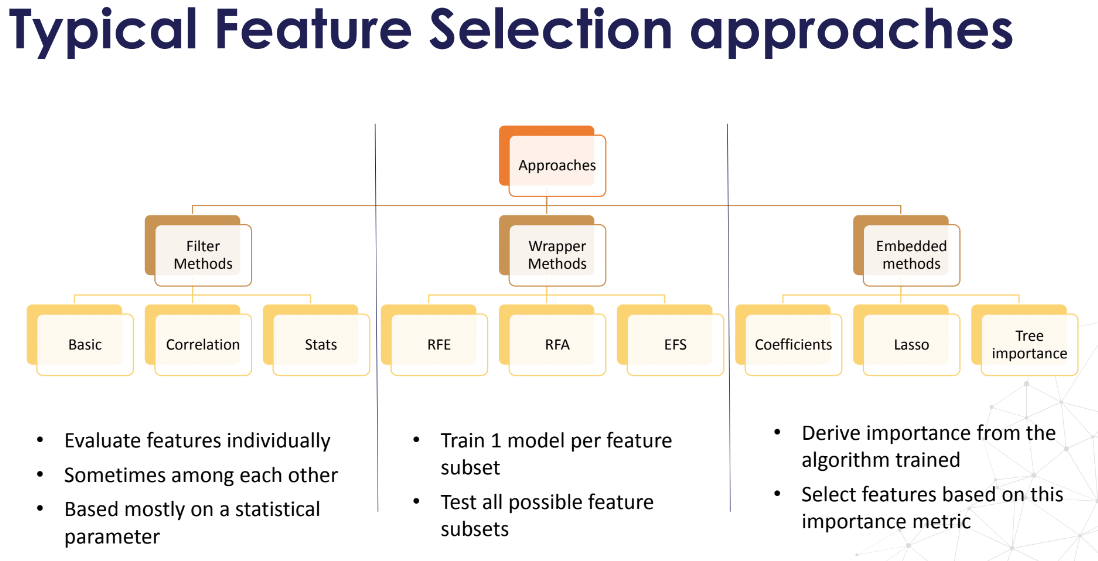

# Feature Selection by Random Shuffling


A popular method of feature selection consists of randomly shuffling the values of a specific variable and determining how that permutation affects the performance metric of the machine learning algorithm. In other words, the idea is to shuffle the values of each feature, one feature at a time, and measure how much the permutation (or shuffling of its values) decreases the accuracy, or the roc_auc, or the mse of the machine learning model (or any other performance metric!). If the variables are important, a random permutation of their values will dramatically decrease any of these metrics. Contrarily, the permutation or shuffling of values should have little to no effect on the model performance metric we are assessing.

**The procedure goes more or less like this:**

* Build a machine learning model and store its performance metrics.
* Shuffle 1 feature, and make a new prediction using the previous model.
* Determine the performance of this prediction.
* Determine the change in the performance of the prediction with the shuffled feature compared to the original one.
* Repeat for each feature.

To select features, we chose those that induced a decrease in model performance beyond an arbitrarily set threshold.

**We use Feature-Engine**

## Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from feature_engine.selection import SelectByShuffling

# Step 1: Initialize the Random Forest Classifier
# We create a RandomForestClassifier with 50 trees and a max depth of 2 for simplicity.
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

# Step 2: Set up SelectByShuffling
# This selects features based on their importance by shuffling.
sel = SelectByShuffling(
    variables=None,  # Automatically examine all numerical variables
    estimator=rf,    # The ML model to evaluate
    scoring='roc_auc',  # The metric to use for evaluation

    #This means any drop in performance, even by a small amount, will lead to the feature being removed.
    threshold=0,     # Maximum performance drop allowed to keep the feature
    cv=3,            # Number of cross-validation folds
    random_state=1   # Seed for reproducibility
)

# Step 3: Fit the feature selector to the training data
sel.fit(X_train, y_train)

# Step 4: Get performance of the model with all features
# This shows the initial performance before feature selection.
sel.initial_model_performance_

# Step 5: Get performance drop caused by shuffling each feature
# This tells us how much performance decreased for each feature.
sel.performance_drifts_

# Step 6: Plot a histogram of the performance drops
# Visualizes the distribution of performance drops after shuffling.
pd.Series(sel.performance_drifts_).hist(bins=50)

# Step 7: Create a bar plot of the performance drops
# This helps to see which features contributed most to performance drops.
pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

# Step 8: Count how many features will be removed
# This shows the number of features identified for removal.
len(sel.features_to_drop_)

# Step 9: Transform the training and testing sets
# Remove the features that are not important.
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

# Display the shapes of the new datasets
X_train.shape, X_test.shape

# Step 10: Fit the Random Forest model on the selected features
rf.fit(X_train, y_train)

# Step 11: Print ROC-AUC scores for train and test sets
# Evaluates the model performance on both training and testing datasets.
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))

As you can see, the random forests with the selected features show a similar performance (or even slightly higher) to the random forests built using all of the features. And it provides a simpler, faster and more reliable model.

## Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from feature_engine.selection import SelectByShuffling

# Step 1: Initialize the Random Forest Regressor
# This model has 100 trees and a max depth of 3 to prevent overfitting.
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=3,
                           random_state=2909,
                           n_jobs=4)

# Step 2: Set up SelectByShuffling
# This will help in selecting important features by shuffling.
sel = SelectByShuffling(
    variables=None,  # Automatically examines all numerical variables
    estimator=rf,    # The estimator (Random Forest in this case)
    scoring='neg_root_mean_squared_error',  # Performance metric for evaluation
    threshold=None,  # Default threshold will be the mean of metric across features
    cv=3,            # Number of cross-validation folds
    random_state=1   # Seed for reproducibility
)

# Step 3: Fit the feature selector to the training data
sel.fit(X_train, y_train)

# Step 4: Get the performance of the model with all features
# This shows the initial performance of the model before feature selection.
sel.initial_model_performance_

# Step 5: Plot performance drifts
# Visualizes how much performance drops when each feature is shuffled.
pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

# Step 6: List the features that will be dropped
# These features are deemed unimportant based on the analysis.
sel.features_to_drop_

# Step 7: Transform the training and testing sets
# Remove the features that are not important.
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

# Step 8: Display the shapes of the new datasets
X_train.shape, X_test.shape

# Step 9: Fit the Random Forest model on the selected features
rf.fit(X_train, y_train)

# Step 10: Print performance metrics for training and test sets
# Evaluates the model performance on both training and testing datasets.
print('train rmse: ', mean_squared_error(y_train, rf.predict(X_train), squared=False))
print('train r2: ', r2_score(y_train, rf.predict(X_train)))
print()
print('test rmse: ', mean_squared_error(y_test, rf.predict(X_test), squared=False))
print('test r2: ', r2_score(y_test, rf.predict(X_test)))

# Hybrid method: Recursive feature elimination


**This method consists of the following steps:**

* Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.
* Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.
* Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.
* If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.
* Repeat steps 2-4 until all features have been evaluated.

**I call this a hybrid method because:**

* it derives the importance derived from the machine learning algorithm, like embedded methods
* it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well.

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

## Remove constant, quasi-constant and duplicated features


In [ ]:
# Step 1: Create a pipeline for feature selection
# This pipeline includes two preprocessing steps:
# 1. DropConstantFeatures to remove features that have a constant value across all samples.
# 2. DropDuplicateFeatures to remove any duplicate features from the dataset.

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),  # Drop features with >99.8% constant values
    ('duplicated', DropDuplicateFeatures()),          # Drop duplicate features
])

# Step 2: Fit the pipeline to the training data
# This will apply the transformations defined in the pipeline to X_train.
pipe.fit(X_train)

# Step 3: Transform the training and testing data
# The fitted pipeline will be used to transform both X_train and X_test,
# removing the specified features.

X_train = pipe.transform(X_train)  # Transformed training set
X_test = pipe.transform(X_test)     # Transformed testing set

# Step 4: Output the shapes of the transformed datasets
X_train.shape, X_test.shape  # Shows the number of features remaining after transformation

## Classification

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Define the ML model for feature selection
# Using a Gradient Boosting Classifier with specific parameters.
model = GradientBoostingClassifier(
    n_estimators=10,  # Number of trees in the ensemble
    max_depth=2,      # Maximum depth of each tree
    random_state=10,  # For reproducibility
)

# Step 2: Set up the Recursive Feature Elimination (RFE) selector
# This will evaluate features based on their contribution to the model's performance.
sel = RecursiveFeatureElimination(
    variables=None,             # Automatically evaluate all numerical variables
    estimator=model,           # The ML model used for evaluation
    scoring='roc_auc',         # The metric for evaluating performance
    threshold=0.0005,          # Maximum performance drop allowed to remove a feature
    cv=2,                       # Number of cross-validation folds
)

# Step 3: Fit the selector to the training data
# This process may take time due to multiple models being built for evaluation.
sel.fit(X_train, y_train)

# Step 4: Get the performance of the model trained using all features
initial_performance = sel.initial_model_performance_

# Step 5: Plot the importance of all features based on the initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

# Step 6: Determine the number of features to be removed
num_features_to_drop = len(sel.features_to_drop_)

# Step 7: Transform the training and testing datasets to keep only selected features
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

# Print the shapes of the new feature sets
X_train.shape, X_test.shape

# Step 8: Fit the model again using only the selected features
model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred_test = model.predict_proba(X_test)[:, 1]

# Step 10: Calculate the ROC AUC score for the model using the selected features
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

## Regression

In [ ]:
# Step 1: Build the initial model using all features
# We create a GradientBoostingRegressor with 10 trees and depth 4.
model = GradientBoostingRegressor(
    n_estimators=10,  # Use 10 trees
    max_depth=4,      # Max depth of each tree is 4
    random_state=10   # Seed for reproducibility
)

# Step 2: Set up the RFE selector
# We set up RFE to select the most important features based on the Gradient Boosting model.
sel = RecursiveFeatureElimination(
    variables=None,    # Automatically evaluate all numerical features
    estimator=model,   # The model to evaluate
    scoring='r2',      # The performance metric to evaluate (R-squared)
    threshold=0.001,   # Maximum allowed drop in performance to remove a feature
    cv=3               # Use 3-fold cross-validation
)

# Step 3: Fit the RFE model to the training data
# Fit the RFE selector on the training data to eliminate irrelevant features.
sel.fit(X_train, y_train)

# Step 4: Check initial model performance with all features
# We check the initial performance of the model using all the features.
sel.initial_model_performance_

# Step 5: Plot feature importance based on the initial model
# Visualize how important each feature is in the initial model.
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Step 6: Output the number of features to be removed
# Count how many features will be removed by the RFE process.
len(sel.features_to_drop_)

# Step 7: Transform the training and testing sets by removing the selected features
# Transform the datasets by keeping only the selected features.
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

# Step 8: Check the shape of the transformed datasets (number of remaining features)
# Verify how many features remain in the transformed datasets.
X_train.shape, X_test.shape

# Step 9: Fit the model using the selected features
# Train the Gradient Boosting model with the selected features.
model.fit(X_train, y_train)

# Step 10: Make predictions on the test set using the selected features
# Use the model to make predictions on the test data.
y_pred_test = model.predict(X_test)

# Step 11: Calculate the R-squared score for the test set
# Calculate the R-squared score to assess the model's performance on the test set.
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features R-squared = %f' % (r2_final))

#Hybrid method: Recursive feature addition

**This method consists of the following steps:**

* Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or coefficients from linear models.
* Build a machine learning model with only 1 feature, the most important one, and calculate the model metric for performance.
* Add one feature -the most important- and build a machine learning algorithm utilising the added and any feature from previous rounds.
* Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy, etc.
* If the metric increases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.
* Repeat steps 2-5 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods
it builds several machine learning models, like wrapper methods.
This method is faster than wrapper methods and often better than embedded methods. In practice it works extremely well.

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

## Classification

In [ ]:
# Step 1: Define the ML model for feature selection
# We create a GradientBoostingClassifier with 10 trees and a max depth of 2.
model = GradientBoostingClassifier(
    n_estimators=10,  # Number of trees
    max_depth=2,      # Maximum depth of each tree
    random_state=10   # Seed for reproducibility
)

# Step 2: Setup the Recursive Feature Addition (RFA) selector
# The RFA will iteratively add features based on their performance increase.
rfa = RecursiveFeatureAddition(
    variables=None,  # Automatically evaluate all numerical features
    estimator=model,  # The machine learning model
    scoring='roc_auc',  # Use ROC-AUC as the evaluation metric
    threshold=0.0001,  # Minimum performance increase to add a feature
    cv=2  # Use 2-fold cross-validation
)

# Step 3: Fit the RFA selector to the training data
# Fit the Recursive Feature Addition on the training data to find the most important features.
rfa.fit(X_train, y_train)

# Step 4: Check initial model performance with all features
# View the performance of the model when trained on all features.
rfa.initial_model_performance_

# Step 5: Plot feature importance based on the initial model
# Visualize the importance of each feature in the initial model.
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Step 6: Count the number of features that will be removed
# Output how many features will be dropped by the Recursive Feature Addition process.
len(rfa.features_to_drop_)

# Step 7: Select and transform the features based on RFA
# Transform the datasets by keeping only the selected features.
X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

# Step 8: Define a final model with the selected features
# We create another GradientBoostingClassifier with the selected features.
model_final = GradientBoostingClassifier(
    n_estimators=10,  # Use 10 trees
    max_depth=2,      # Maximum tree depth of 2
    random_state=10   # Seed for reproducibility
)

# Step 9: Fit the final model with the selected features
# Train the model using only the selected features from the RFA.
model_final.fit(X_train, y_train)

# Step 10: Make predictions on the test set using the selected features
# Use the final model to make predictions on the test data.
y_pred_test = model_final.predict_proba(X_test)[:, 1]

# Step 11: Calculate the ROC-AUC score for the test set
# Evaluate the performance of the model with the selected features.
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

## Regression

In [ ]:
# Step 1: Define the Gradient Boosting model for regression
# Create a GradientBoostingRegressor with 10 trees and max depth of 4.
model = GradientBoostingRegressor(
    n_estimators=10,  # Number of trees
    max_depth=4,      # Maximum depth of each tree
    random_state=10   # Seed for reproducibility
)

# Step 2: Setup Recursive Feature Addition (RFA) selector
# The RFA will add features based on their contribution to model performance.
rfa = RecursiveFeatureAddition(
    variables=None,  # Automatically evaluate all numerical features
    estimator=model,  # Use GradientBoostingRegressor for feature evaluation
    scoring='r2',  # Evaluate model using R-squared metric
    threshold=0.001,  # Minimum performance increase to add a feature
    cv=2  # Use 2-fold cross-validation
)

# Step 3: Fit RFA to the training data
# Fit the Recursive Feature Addition on the training set to identify important features.
rfa.fit(X_train, y_train)

# Step 4: Check initial model performance with all features
# View the performance of the initial model when all features are used.
rfa.initial_model_performance_

# Step 5: Plot feature importance from the initial model
# Visualize how important each feature is in the initial model.
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Step 6: Count the number of features that will be removed
# Output how many features will be dropped after the Recursive Feature Addition.
len(rfa.features_to_drop_)

# Step 7: Select and transform the dataset with RFA
# Keep only the selected features and update X_train and X_test.
X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

# Step 8: Display the new shape of X_train and X_test
# Check how many features remain in the transformed datasets.
X_train.shape, X_test.shape

# Step 9: Define a new Gradient Boosting model using the selected features
# Create a new model that will be trained on the selected features only.
model_final = GradientBoostingRegressor(
    n_estimators=10,  # Use 10 trees
    max_depth=4,      # Maximum depth of each tree
    random_state=10   # Seed for reproducibility
)

# Step 10: Fit the final model with selected features
# Train the Gradient Boosting model on the reduced feature set.
model_final.fit(X_train, y_train)

# Step 11: Make predictions on the test data
# Use the final model to predict on the test set using selected features.
y_pred_test = model_final.predict(X_test)

# Step 12: Calculate R-squared for the test set
# Evaluate the performance of the final model using R-squared.
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features R-squared = %f' % (r2_final))

**To see all Feature Selection methods**
* [Feature Selection](https://github.com/solegalli/feature-selection-for-machine-learning/blob/main/README.md)